# Get brain tissues mask from the ground truth

100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


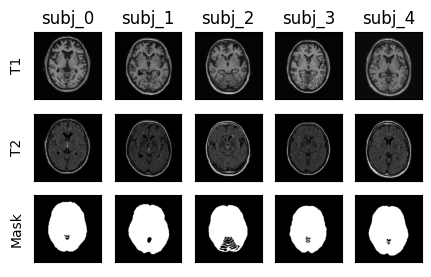

In [1]:
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import utils as utils

data_path = Path('/home/jseia/Desktop/MAIA/Clases/spain/misa/misa_lab/data/P2_data')

# Get brain masks from labels
for i in tqdm(range(5)):
    path = data_path / f'{i+1}/LabelsForTesting.nii'
    brain_mask = sitk.ReadImage(path)
    bm_array = sitk.GetArrayFromImage(brain_mask)
    bm_array = np.where(bm_array > 0, 255, 0).astype('uint8')
    img = sitk.GetImageFromArray(np.where(bm_array>0, 255, 0))
    img.SetDirection(brain_mask.GetDirection())
    img.SetOrigin(brain_mask.GetOrigin())
    img.SetSpacing(brain_mask.GetSpacing())
    path = data_path / f'{i+1}/brain_mask.nii'
    sitk.WriteImage(img, path)
    
slice_n = 20
fig, ax = plt.subplots(3, 5, figsize=(5, 3))
for i in range(5):
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    bm = sitk.GetArrayFromImage(bm)
    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')
    
    titles = ['T1', 'T2', 'Mask']
    for k, img in enumerate([t1_array, t2_array, bm]):
        if k == 0:
            ax[k, i].set_title(f'subj_{i}')
        ax[k, i].set_xticks([])
        ax[k, i].set_yticks([])
        if i == 0:
            ax[k, i].set_ylabel(titles[k])
        ax[k, i].imshow(img[slice_n, :, :], cmap='gray')
plt.show()

## Compare the different initializations for EM

In [2]:
import utils
import pandas as pd
import seaborn as sns
from pathlib import Path

-------------------- Subject N°1 --------------------


 33%|███▎      | 33/100 [00:04<00:10,  6.69it/s]


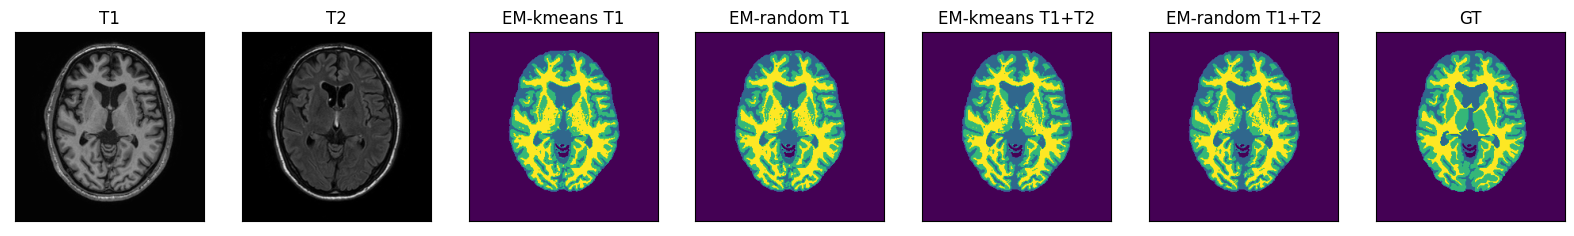

-------------------- Subject N°2 --------------------


 43%|████▎     | 43/100 [00:06<00:09,  6.22it/s]


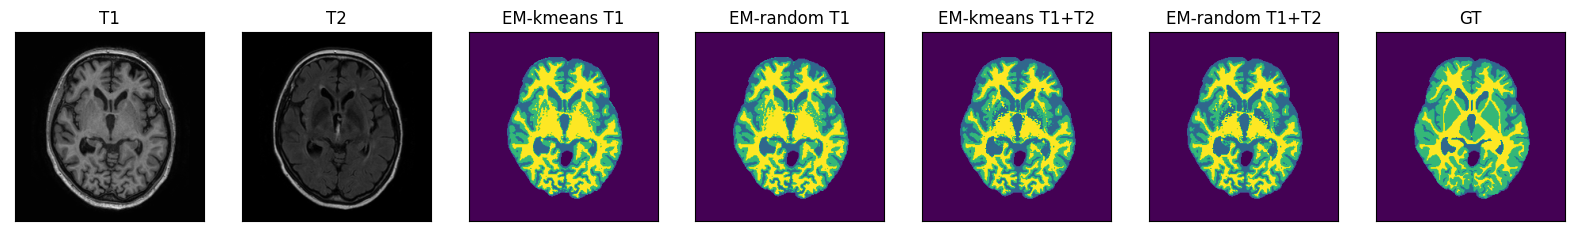

-------------------- Subject N°3 --------------------


 44%|████▍     | 44/100 [00:06<00:08,  6.84it/s]


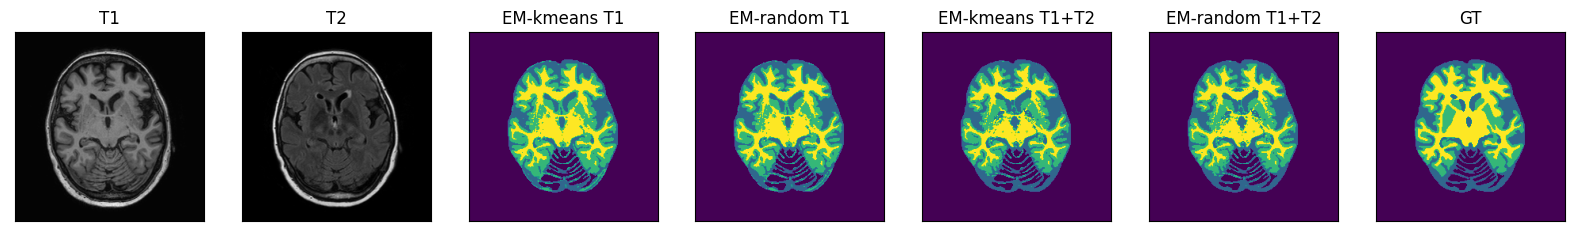

-------------------- Subject N°4 --------------------


 38%|███▊      | 38/100 [00:05<00:08,  7.39it/s]


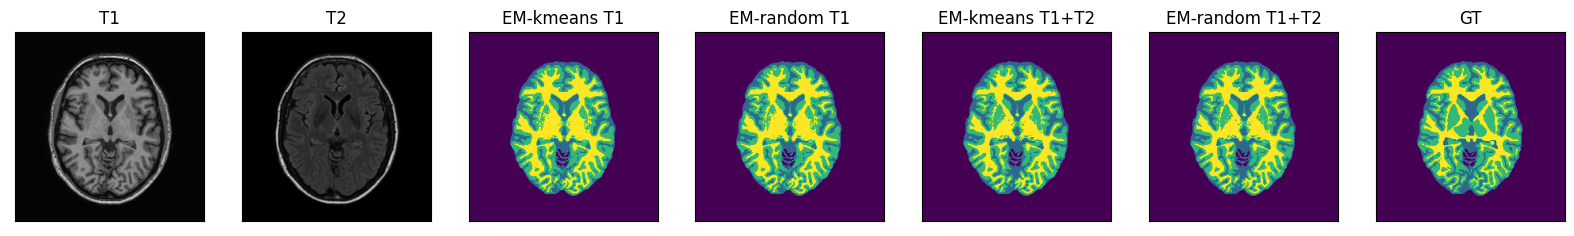

-------------------- Subject N°5 --------------------


 37%|███▋      | 37/100 [00:05<00:08,  7.04it/s]


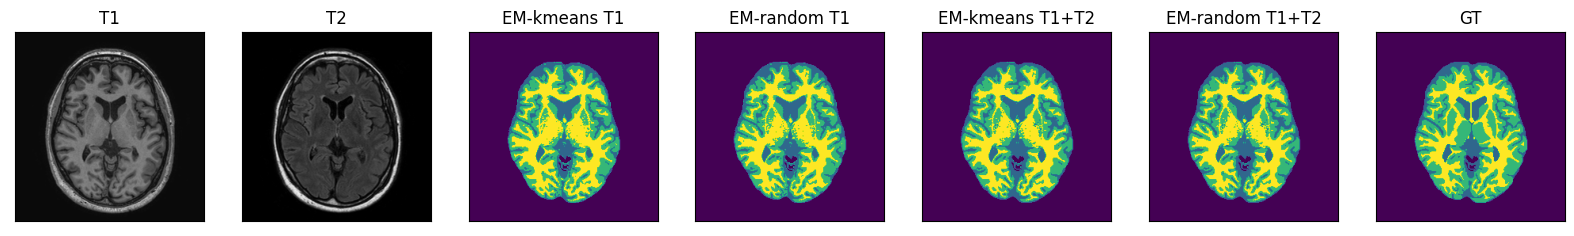

,CSF,GM,WM,modalities,subject,model,init,time,iterations
0,0.882218,0.804676,0.873681,T1,0,EM,kmeans,5.563374,36
1,0.910199,0.827160,0.872242,T1+T2,0,EM,kmeans,11.482559,43
2,0.882218,0.804676,0.873681,T1,0,EM,random,5.039386,34
3,0.910199,0.827160,0.872242,T1+T2,0,EM,random,9.450511,46
4,0.861839,0.747046,0.790446,T1,1,EM,kmeans,4.851029,28
5,0.830954,0.765768,0.808822,T1+T2,1,EM,kmeans,12.779329,46
6,0.861839,0.747046,0.790446,T1,1,EM,random,7.012151,44
7,0.830954,0.765768,0.808822,T1+T2,1,EM,random,16.386771,79
8,0.869159,0.796462,0.875043,T1,2,EM,kmeans,5.400397,30
9,0.864776,0.791535,0.866316,T1+T2,2,EM,kmeans,11.058853,43


In [3]:
data_path = Path.cwd().parent / 'data/P2_data'

dice_scores = []
for i in range(5):
    print(f'{"-"*20} Subject N°{i + 1} {"-"*20}')
    
    # Load images
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    gt = sitk.ReadImage(data_path / f'{i+1}/LabelsForTesting.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')
    spm_seg_t1_t2 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1_t2.nii')
    spm_seg_t1 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1.nii')

    # Get arrays
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    gt_array = sitk.GetArrayFromImage(gt)
    bm = sitk.GetArrayFromImage(bm)
    spm_seg_t1_t2_array = sitk.GetArrayFromImage(spm_seg_t1_t2)
    spm_seg_t1_array = sitk.GetArrayFromImage(spm_seg_t1)

    # Cast images de uint8
    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')

    # Segement Brain
    t1_seg_res_em_km, t1_t2_seg_res_em_km, t_t1_em_km, t_t1_t2_em_km, its_t1_em_km, its_t1_t2_em_km = \
        utils.brain_tissue_segmentation(t1_array, t2_array, bm, 'em', 'kmeans')
    t1_seg_res_em_rnd, t1_t2_seg_res_em_rnd, t_t1_em_rnd, t_t1_t2_em_rnd, its_t1_em_rnd, its_t1_t2_em_rnd = \
        utils.brain_tissue_segmentation(t1_array, t2_array, bm, 'em', 'random')

    # Correct labels to match groun truth
    t1_seg_res_em_km = utils.match_pred_w_gt(t1_seg_res_em_km, gt_array, t1_array)
    t1_t2_seg_res_em_km = utils.match_pred_w_gt(t1_t2_seg_res_em_km, gt_array, t1_array, t2_array)
    t1_seg_res_em_rnd = utils.match_pred_w_gt(t1_seg_res_em_rnd, gt_array, t1_array)
    t1_t2_seg_res_em_rnd = utils.match_pred_w_gt(t1_t2_seg_res_em_rnd, gt_array, t1_array, t2_array)

    # Get dice scores
    dice_scores.append(utils.dice_score(
        gt_array, t1_seg_res_em_km) + ['T1', i, 'EM', 'kmeans', t_t1_em_km, its_t1_em_km])
    dice_scores.append(utils.dice_score(
            gt_array, t1_t2_seg_res_em_km) + ['T1+T2', i, 'EM', 'kmeans', t_t1_t2_em_km, its_t1_t2_em_km])
    dice_scores.append(utils.dice_score(
        gt_array, t1_seg_res_em_rnd) + ['T1', i, 'EM', 'random', t_t1_em_rnd, its_t1_em_rnd])
    dice_scores.append(utils.dice_score(
        gt_array, t1_t2_seg_res_em_rnd) + ['T1+T2', i, 'EM', 'random', t_t1_t2_em_rnd, its_t1_t2_em_rnd])
    
    # Plot
    volumes = [t1_array, t2_array, t1_seg_res_em_km, t1_seg_res_em_rnd,
               t1_t2_seg_res_em_km, t1_t2_seg_res_em_rnd, gt_array]
    names = ['T1', 'T2', 'EM-kmeans T1', 'EM-random T1', 'EM-kmeans T1+T2', 'EM-random T1+T2', 'GT']
    utils.plots(volumes, names, slice_n = 20)
    
    # break
    # Save images
    utils.save_segementations(t1_seg_res_em_km, spm_seg_t1_t2, data_path / f'{i+1}/em_km_seg_t1.nii')
    utils.save_segementations(t1_seg_res_em_rnd, spm_seg_t1_t2, data_path / f'{i+1}/em_rnd_seg_t1.nii')
    utils.save_segementations(t1_t2_seg_res_em_km, spm_seg_t1_t2, data_path / f'{i+1}/em_km_seg_t1_t2.nii')
    utils.save_segementations(t1_t2_seg_res_em_rnd, spm_seg_t1_t2, data_path / f'{i+1}/em_rnd_seg_t1_t2.nii')

columns = ['CSF', 'GM', 'WM', 'modalities', 'subject', 'model', 'init', 'time', 'iterations']
dice_scores = pd.DataFrame(data=dice_scores, columns=columns)
dice_scores.to_csv('dice_scores_init.csv')
dice_scores

### Visualize all results

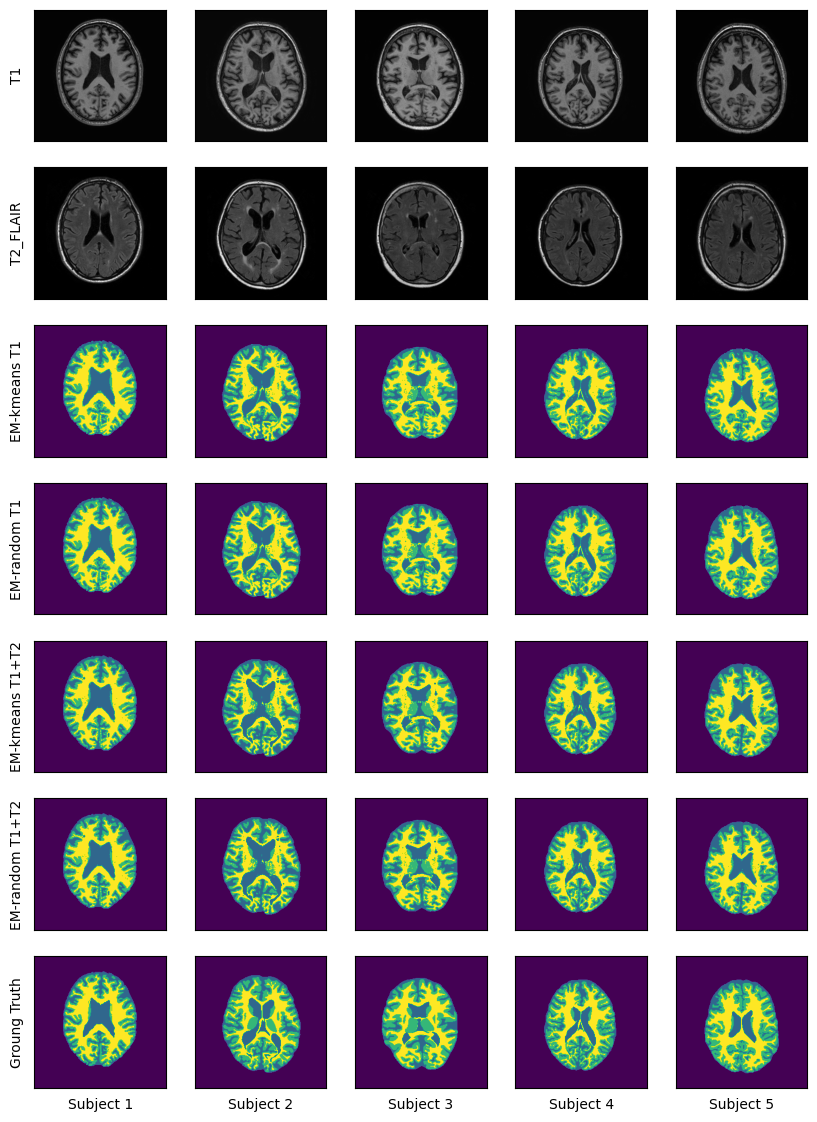

In [4]:
img_names = [
    'T1.nii', 'T2_FLAIR.nii', 'em_km_seg_t1.nii', 'em_rnd_seg_t1.nii',
    'em_km_seg_t1_t2.nii', 'em_rnd_seg_t1_t2.nii', 'LabelsForTesting.nii'
]
ylabels = [
    'T1', 'T2_FLAIR', 'EM-kmeans T1', 'EM-random T1',
    'EM-kmeans T1+T2', 'EM-random T1+T2', 'Groung Truth'
]
utils.complete_figure(data_path, img_names, ylabels, slice_n = 25)

### Get analysis boxplots

In [5]:
df = pd.melt(dice_scores, id_vars=['modalities', 'subject', 'model', 'init', 'time'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df['model'] = df['model'].str.upper()
df.columns = ['Modalities', 'Subject', 'Model', 'Init', 'Time', 'Tissue', 'Dice']

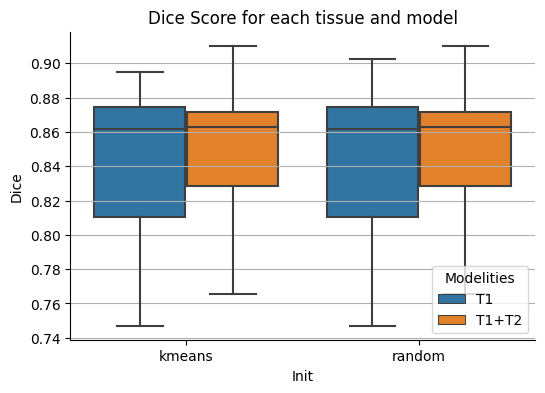

In [6]:
plt.figure(figsize=(6,4))
plt.title('Dice Score for each tissue and model')
sns.boxplot(data=df, x="Init", y="Dice", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

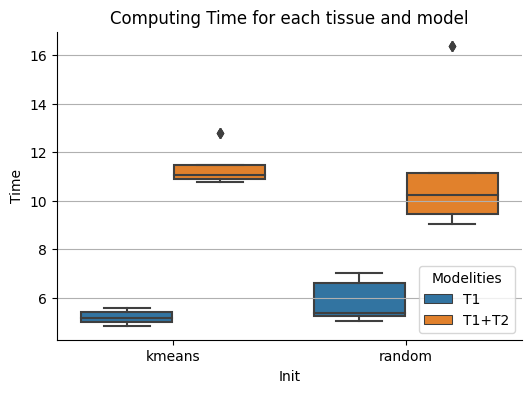

In [7]:
plt.figure(figsize=(6,4))
plt.title('Computing Time for each tissue and model')
sns.boxplot(data=df, x="Init", y="Time", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

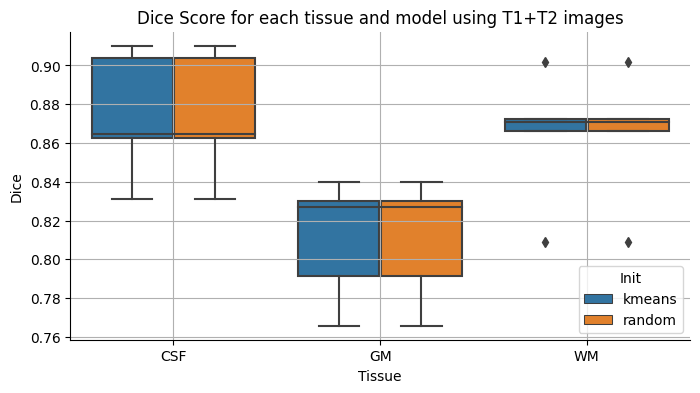

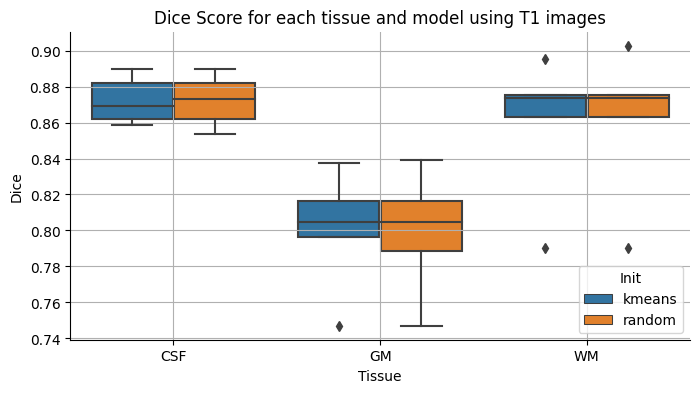

In [8]:
df_ = df.loc[df.Modalities == 'T1+T2']
plt.figure(figsize=(8,4))
plt.title('Dice Score for each tissue and model using T1+T2 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Init")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Init')
plt.show()

df_ = df.loc[df.Modalities == 'T1']
plt.figure(figsize=(8,4))
plt.title('Dice Score for each tissue and model using T1 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Init")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Init')
plt.show()

# Compare EM-kmeans (best from before) vs KM vs SPM

-------------------- Subject N°1 --------------------


 35%|███▌      | 35/100 [00:04<00:08,  7.32it/s]


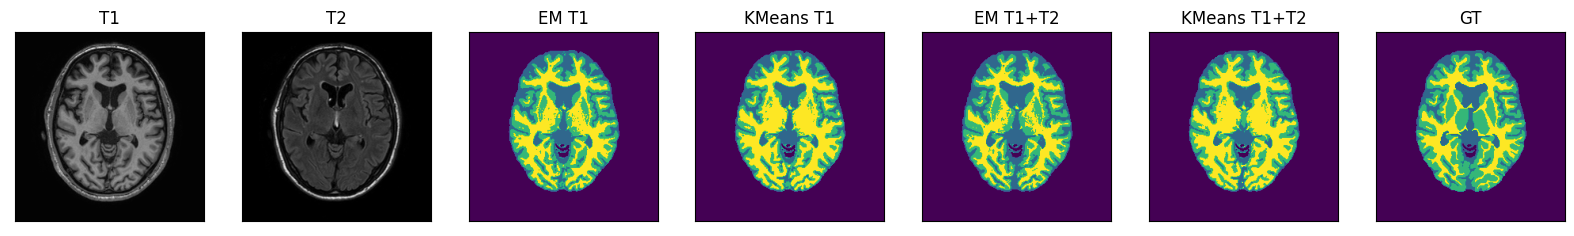

-------------------- Subject N°2 --------------------


 27%|██▋       | 27/100 [00:04<00:11,  6.57it/s]


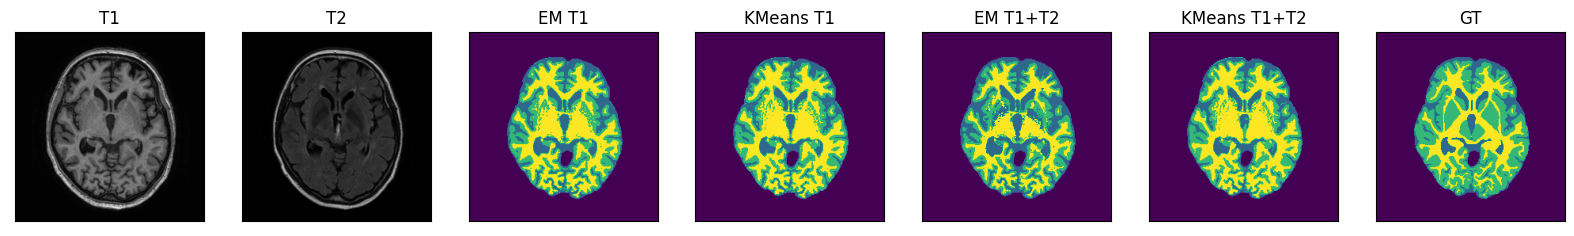

-------------------- Subject N°3 --------------------


 29%|██▉       | 29/100 [00:04<00:10,  7.02it/s]


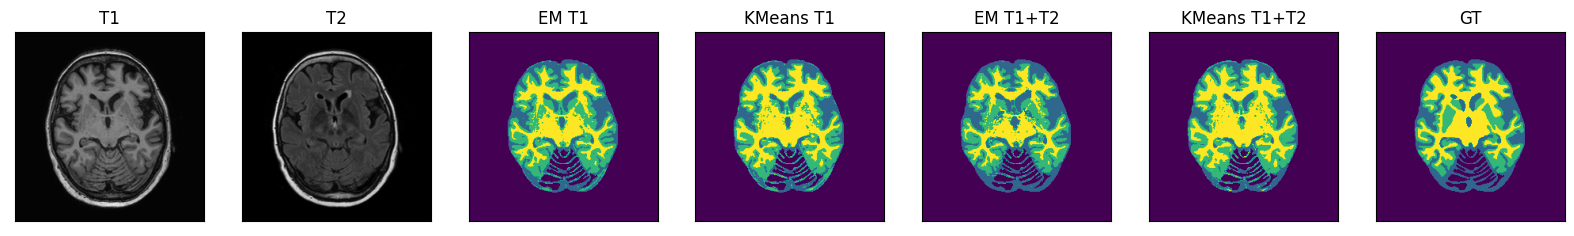

-------------------- Subject N°4 --------------------


 28%|██▊       | 28/100 [00:04<00:10,  6.74it/s]


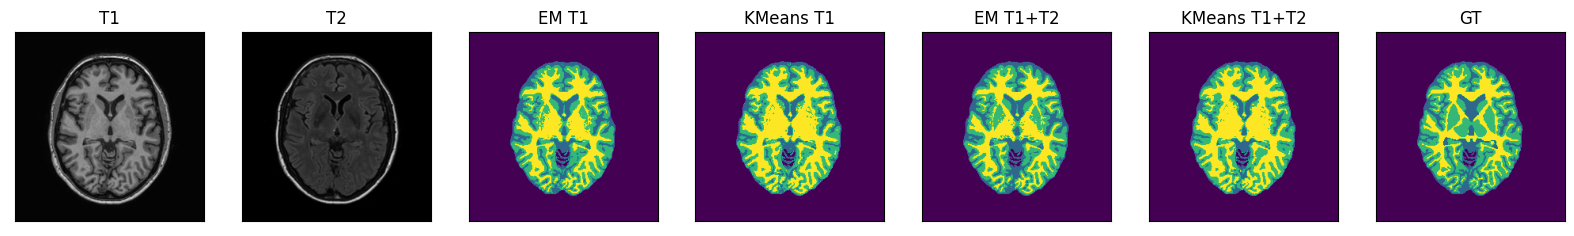

-------------------- Subject N°5 --------------------


 25%|██▌       | 25/100 [00:04<00:13,  5.60it/s]


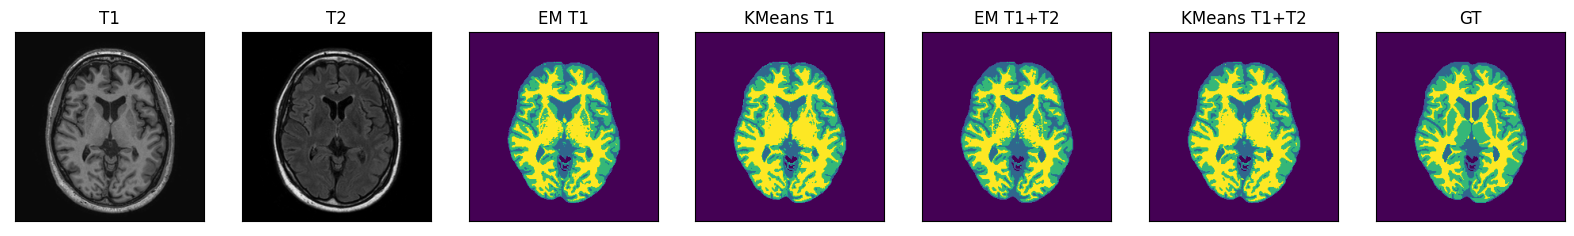

,CSF,GM,WM,modalities,subject,model,time,iterations
0,0.860584,0.718997,0.823797,T1,0,KM,0.596590,3
1,0.823519,0.693650,0.813805,T1+T2,0,KM,2.115904,4
2,0.882218,0.804676,0.873681,T1,0,EM,5.489656,36
3,0.910199,0.827160,0.872242,T1+T2,0,EM,9.861746,43
4,0.797686,0.753831,0.825104,T1,0,SPM,0.000000,0
5,0.798009,0.760439,0.830556,T1+T2,0,SPM,0.000000,0
6,0.859679,0.731763,0.769978,T1,1,KM,0.714222,11
7,0.869770,0.728203,0.762240,T1+T2,1,KM,2.793490,4
8,0.861839,0.747046,0.790446,T1,1,EM,5.091878,28
9,0.830954,0.765768,0.808822,T1+T2,1,EM,12.077586,46


In [9]:
data_path = Path.cwd().parent / 'data/P2_data'

dice_scores = []
for i in range(5):
    print(f'{"-"*20} Subject N°{i + 1} {"-"*20}')
    
    # Load images
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    gt = sitk.ReadImage(data_path / f'{i+1}/LabelsForTesting.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')
    spm_seg_t1_t2 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1_t2.nii')
    spm_seg_t1 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1.nii')

    # Get arrays
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    gt_array = sitk.GetArrayFromImage(gt)
    bm = sitk.GetArrayFromImage(bm)
    spm_seg_t1_t2_array = sitk.GetArrayFromImage(spm_seg_t1_t2)
    spm_seg_t1_array = sitk.GetArrayFromImage(spm_seg_t1)

    # Cast images de uint8
    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')

    # Segement Brain
    t1_seg_res_em, t1_t2_seg_res_em, t_t1_em, t_t1_t2_em, its_t1_em, its_t1_t2_em = \
        utils.brain_tissue_segmentation(t1_array, t2_array, bm, 'em', 'kmeans')
    t1_seg_res_km, t1_t2_seg_res_km, t_t1_km, t_t1_t2_km, its_t1_km, its_t1_t2_km = \
        utils.brain_tissue_segmentation(t1_array, t2_array, bm, 'km', 'kmeans')

    # Correct labels to match groun truth
    t1_seg_res_em = utils.match_pred_w_gt(t1_seg_res_em, gt_array, t1_array)
    t1_t2_seg_res_em = utils.match_pred_w_gt(t1_t2_seg_res_em, gt_array, t1_array, t2_array)
    t1_seg_res_km = utils.match_pred_w_gt(t1_seg_res_km, gt_array, t1_array)
    t1_t2_seg_res_km = utils.match_pred_w_gt(t1_t2_seg_res_km, gt_array, t1_array, t2_array)
    spm_seg_t1_t2_array = utils.match_pred_w_gt(spm_seg_t1_t2_array, gt_array, t1_array, t2_array)
    spm_seg_t1_array = utils.match_pred_w_gt(spm_seg_t1_array, gt_array, t1_array, t2_array)

    # Get dice scores
    dice_scores.append(utils.dice_score(
        gt_array, t1_seg_res_km) + ['T1', i, 'KM', t_t1_km, its_t1_km])
    dice_scores.append(utils.dice_score(
        gt_array, t1_t2_seg_res_km) + ['T1+T2', i, 'KM', t_t1_t2_km, its_t1_t2_km])
    dice_scores.append(utils.dice_score(
        gt_array, t1_seg_res_em) + ['T1', i, 'EM', t_t1_em, its_t1_em])
    dice_scores.append(utils.dice_score(
        gt_array, t1_t2_seg_res_em) + ['T1+T2', i, 'EM', t_t1_t2_em, its_t1_t2_em])
    dice_scores.append(utils.dice_score(
        gt_array, spm_seg_t1_array) + ['T1', i, 'SPM', 0, 0])
    dice_scores.append(utils.dice_score(
        gt_array, spm_seg_t1_t2_array) + ['T1+T2', i, 'SPM', 0, 0])
    
    # Plot
    volumes = [t1_array, t2_array, t1_seg_res_em, t1_seg_res_km, t1_t2_seg_res_em, t1_t2_seg_res_km, gt_array]
    names = ['T1', 'T2', 'EM T1', 'KMeans T1', 'EM T1+T2', 'KMeans T1+T2', 'GT']
    utils.plots(volumes, names, slice_n = 20)
    
    # Save images
    utils.save_segementations(t1_seg_res_em, spm_seg_t1_t2, data_path / f'{i+1}/em_seg_t1.nii')
    utils.save_segementations(t1_seg_res_km, spm_seg_t1_t2, data_path / f'{i+1}/km_seg_t1.nii')
    utils.save_segementations(t1_t2_seg_res_em, spm_seg_t1_t2, data_path / f'{i+1}/em_seg_t1_t2.nii')
    utils.save_segementations(t1_t2_seg_res_km, spm_seg_t1_t2, data_path / f'{i+1}/km_seg_t1_t2.nii')

columns = ['CSF', 'GM', 'WM', 'modalities', 'subject', 'model', 'time', 'iterations']
dice_scores = pd.DataFrame(data=dice_scores, columns=columns)
dice_scores.to_csv('dice_scores.csv')
dice_scores

### Visualize the results

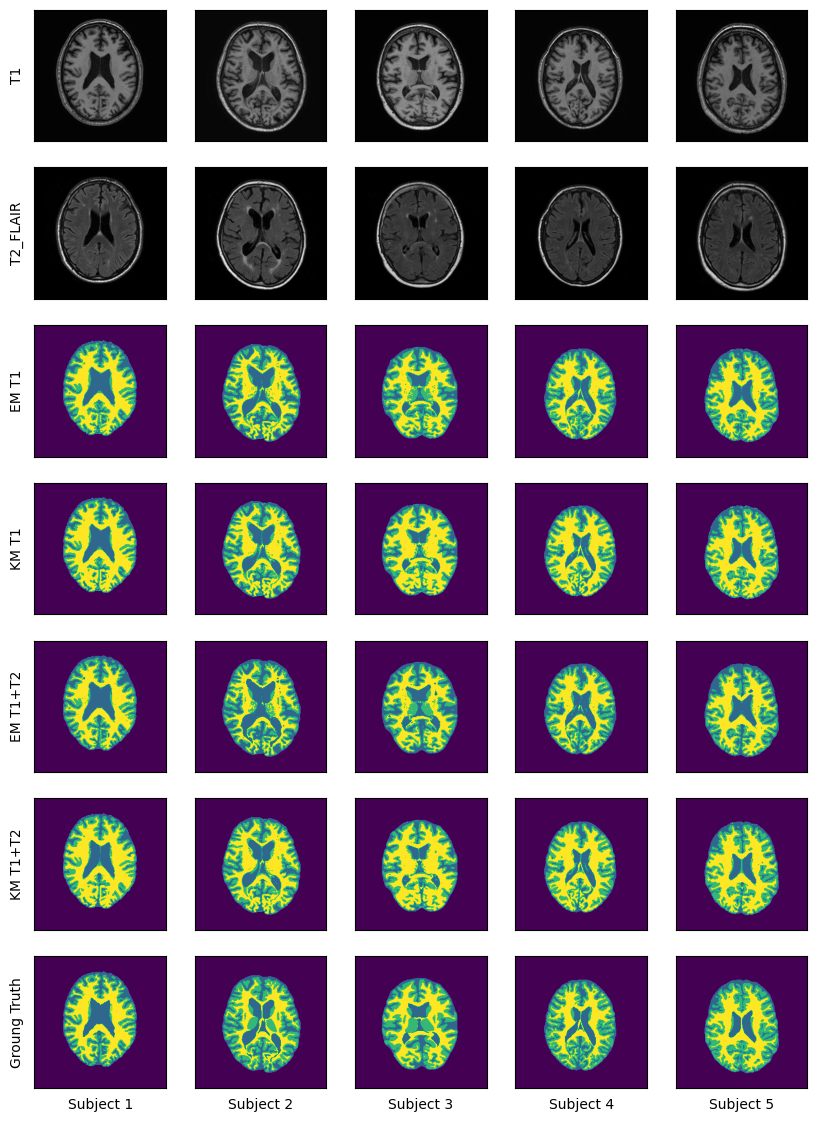

In [10]:
img_names = [
    'T1.nii', 'T2_FLAIR.nii', 'em_seg_t1.nii', 'km_seg_t1.nii',
    'em_seg_t1_t2.nii', 'km_seg_t1_t2.nii', 'LabelsForTesting.nii'
]
ylabels = [
    'T1', 'T2_FLAIR', 'EM T1', 'KM T1',
    'EM T1+T2', 'KM T1+T2', 'Groung Truth'
]
utils.complete_figure(data_path, img_names, ylabels, slice_n = 25)

### Get analysis boxplots

In [11]:
df = pd.melt(dice_scores, id_vars=['modalities', 'subject', 'model', 'time'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df['model'] = df['model'].str.upper()
df.columns = ['Modalities', 'Subject', 'Model', 'Time', 'Tissue', 'Dice']

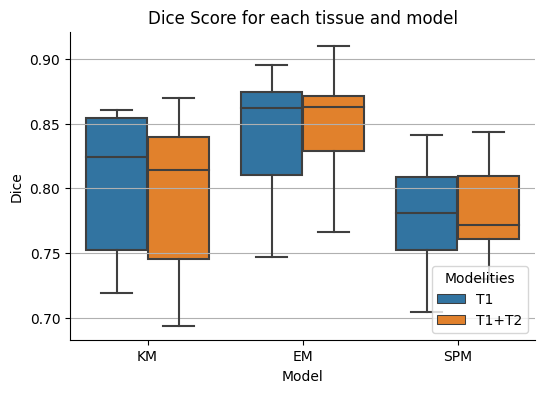

In [12]:
plt.figure(figsize=(6,4))
plt.title('Dice Score for each tissue and model')
sns.boxplot(data=df, x="Model", y="Dice", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

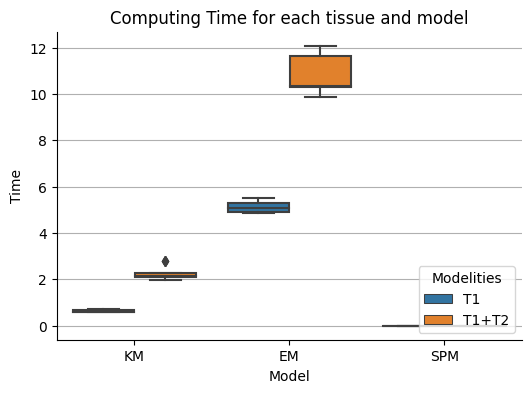

In [13]:
plt.figure(figsize=(6,4))
plt.title('Computing Time for each tissue and model')
sns.boxplot(data=df, x="Model", y="Time", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

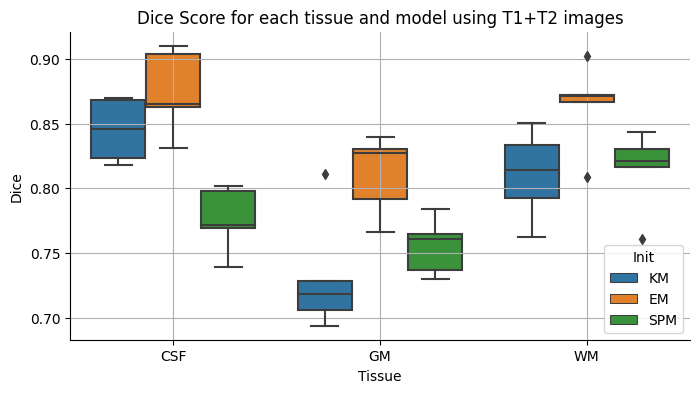

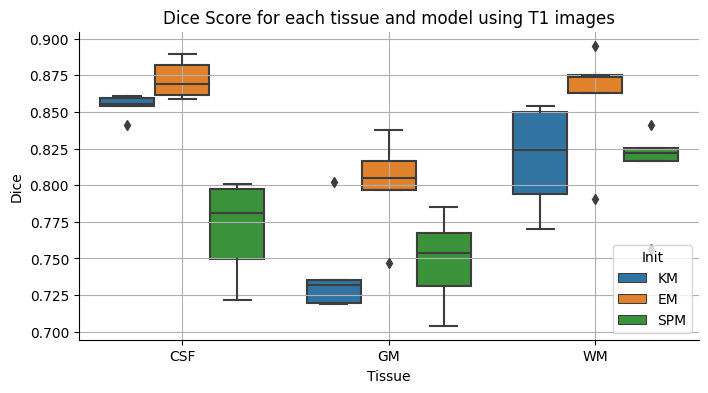

In [14]:
df_ = df.loc[df.Modalities == 'T1+T2']
plt.figure(figsize=(8,4))
plt.title('Dice Score for each tissue and model using T1+T2 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Init')
plt.show()

df_ = df.loc[df.Modalities == 'T1']
plt.figure(figsize=(8,4))
plt.title('Dice Score for each tissue and model using T1 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Init')
plt.show()